# Import dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Exploratory Climate Analysis
## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract


In [5]:
#Connect to SQLite database 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Precipitation Analysis 

In [9]:
#Query last date in dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]


In [10]:
#Find date 12 months prior to last date 
year_date = dt.datetime.strptime(last_date,'%Y-%m-%d')-dt.timedelta(days=366)

last_date, year_date

('2017-08-23', datetime.datetime(2016, 8, 22, 0, 0))

In [11]:
#Query date and prcp in last 12 months 
year_prcp = session.query(Measurement.date, Measurement.prcp).\
 filter(Measurement.date >= year_date).all()


In [12]:
# Load query results into Pandas Dataframe
year_prcp_df = pd.DataFrame(year_prcp, columns=['date', 'precipitation'])

# Set the index to the date column
year_prcp_df.set_index('date', inplace=True)


In [13]:
# Sort the dataframe by date
year_prcp_df = year_prcp_df.sort_values('date')


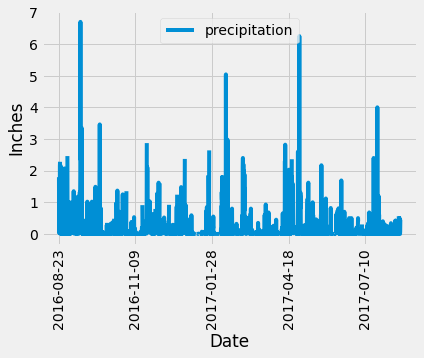

In [14]:
# Plot the results using the DataFrame `plot` method.
ax = year_prcp_df.plot(rot = 90)
plt.legend(['precipitation'])
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.show()

In [15]:
# Use Pandas to print the summary statistics for the precipitation data.
year_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis 

In [16]:
#Find columns in Station class 
inspector = inspect(engine) 
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'])


id
station
name
latitude
longitude
elevation


In [17]:
#Design a query to show total number of stations 
session.query(Station.station).count()


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# calculate highest, lowest and avg temperature recorded of the most active station
station_id = 'USC00519281'
session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == station_id).all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Query date and prcp in last 12 months 
temp = session.query(Measurement.date, Measurement.tobs).\
 filter(Measurement.date >= year_date).filter(Measurement.station == station_id).all()

# Load query results into Pandas Dataframe
temp_df = pd.DataFrame(temp, columns=['date', 'tobs'])

# Set the index to the date column and sort by date
temp_df.set_index('date', inplace=True)
temp_df = temp_df.sort_values('date')


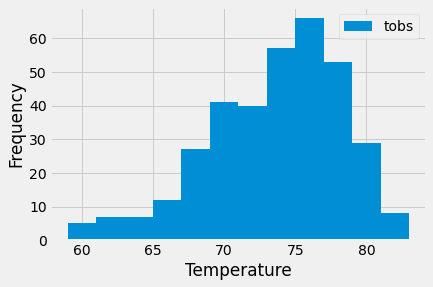

In [21]:
ax = temp_df.tobs.hist(bins=12)

ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.legend(['tobs'], loc = "upper right")

plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I
Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
* Answer: We will use unpaired t-test since June and December temperatures are independent of each other.
    The p-value is 3.9x10-191 which shows that the difference in means of June and December temperatures are statistically significant*

In [22]:
#Calculate average temperature in June 
June_temp = session.query(Measurement.date, Measurement.tobs).\
filter(extract('month', Measurement.date)==6).all()      
June = pd.DataFrame(June_temp, columns=['Date', 'Temperature'])
june_average = June['Temperature'].mean()
june_average

74.94411764705882

In [23]:
#Calculate average temperature in December
Dec_temp = session.query(Measurement.date, Measurement.tobs).\
filter(extract('month', Measurement.date)==12).all()
Dec = pd.DataFrame(Dec_temp, columns=['Date', 'Temperature'])
dec_average = June['Temperature'].mean()
dec_average

74.94411764705882

In [24]:
from scipy import stats
from numpy import mean

In [25]:
# Perform unpaired t-test 
stats.ttest_ind(June['Temperature'], Dec['Temperature']) 


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Temperature Analysis II 

Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

Plot the min, avg, and max temperature from your previous query as a bar chart.

Use the average temperature as the bar height.

Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-08-20', '2011-08-30'))


[(70.0, 75.58108108108108, 82.0)]


In [27]:
# print(calc_temps('2010-08-20', '2010-08-30'))

In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# function usage example
start = '2011-08-20'
end = '2011-08-30'

start_date = dt.datetime.strptime(start,'%Y-%m-%d')-dt.timedelta(days=365)
end_date = dt.datetime.strptime(end,'%Y-%m-%d')-dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(start_date, end_date)[0]
print(tmin, tavg, tmax)

68.0 75.29268292682927 87.0


Text(0, 0.5, 'Temp (F)')

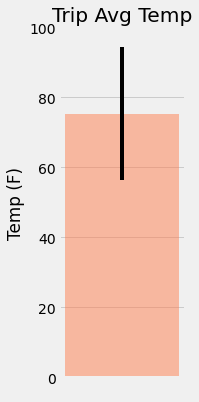

In [64]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,6))

plt.bar(x=' ', height = tavg, yerr = tmax-tmin, color='coral', alpha = 0.5)
plt.ylim(0,100)
plt.grid(axis='y')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')


### Daily Rainful Average

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
session.query(*sel).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
                                           


[(3.94,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (1.4300000000000002,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (1.18, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (0.6,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.29,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.27,
  'USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 (0.24000000000000002,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (0.0, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (0.0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [59]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

Did not complete the remainder of the Bonus section 
